### Sentiment analysis on twitter tweets that reflects the sentiment of customers of major airlines. 

* Exploratory analysis to understand sentiment distribution of customers across various airlines.
* Preprocessing of tweets by removing URLS, mentions and replacing # by keyword "hashtag".
* Use Multinomial Naive Bayes and Logistic regression to learn and predict customer sentiments.
* Plot a learning-curve for both models.

#### Loading Data: -

In [5]:
import numpy as np
import pandas as pd

df = pd.read_csv("Tweets.csv", header=0, delimiter=",", quoting=0)

In [18]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
data = pd.DataFrame(df[["airline_sentiment","airline","text"]])

data["airline_sentiment"] = data["airline_sentiment"].map({'positive':3,'neutral':2,'negative':1})

airline_names = data.airline.unique()


#### Q1: Load all data and plot the sentiment distribution for each airline.

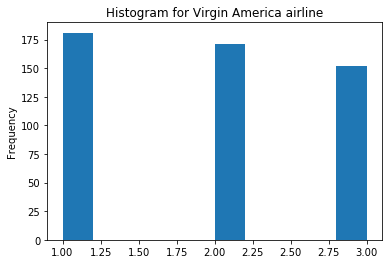

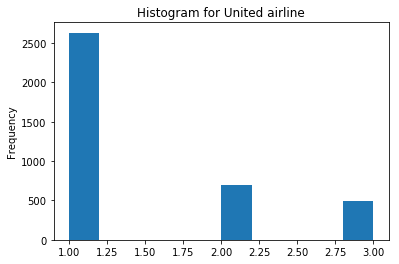

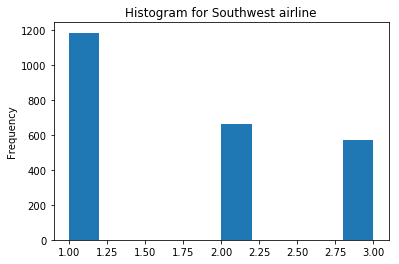

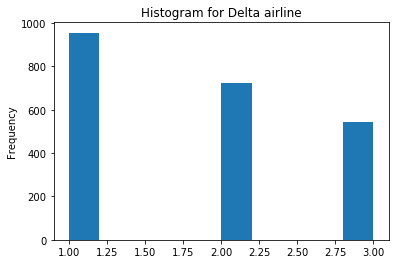

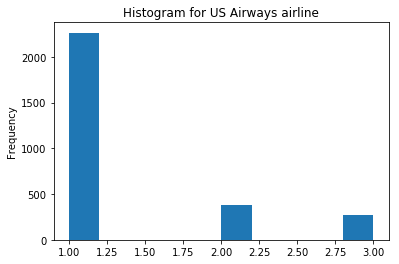

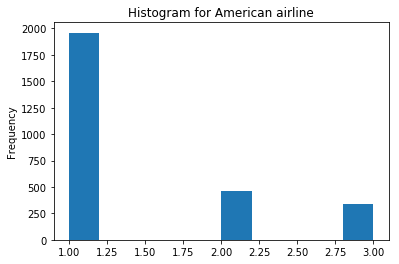

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(len(airline_names)):
    temp = data[data["airline"].str.match(airline_names[i])]
    temp["airline_sentiment"].plot.hist()
    plt.title("Histogram for "+airline_names[i]+" airline")
    plt.show()


#### Analysis : -
* Virgin airlines is having an almost even distribution of positive, negative and neutral sentiments.
* Tweets mentioning United, US Airways and American airlines are having high number of negative sentiments.
* All airlines are having more tweets with negative sentiments than positive or neutral.

In [8]:
import re

regexp_hashtag = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)'
pattern_hashtag = re.compile(regexp_hashtag, re.UNICODE | re.IGNORECASE)
regexp_mention = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
pattern_mention = re.compile(regexp_mention, re.UNICODE | re.IGNORECASE)
regexp_url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern_url = re.compile(regexp_url, re.UNICODE | re.IGNORECASE)

def preprocess(text):
    #Remove URLs 
    temp = pattern_url.sub('',text)
    #Remove intermediate periods to better detect mentions
    temp = re.sub('\.(?!$)', '',temp)
    #Remove Mentions
    temp = pattern_mention.sub('',temp)
    #Replace hashtags
    temp = pattern_hashtag.sub(r' hashtag_\1',temp)
    #Removing \n RT : and leading spaces
    return temp

data.head(5)


,airline_sentiment,airline,text
0,2,Virgin America,@VirginAmerica What @dhepburn said.
1,3,Virgin America,@VirginAmerica plus you've added commercials t...
2,2,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,1,Virgin America,@VirginAmerica it's really aggressive to blast...
4,1,Virgin America,@VirginAmerica and it's a really big bad thing...


#### Q2: Remove URLs and mentions and rename hashtag sign to ‘hashtag_’

In [9]:
for i  in range(len(data)):
    data["text"][i] = preprocess(data["text"][i])
data.head(5)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,airline_sentiment,airline,text
0,2,Virgin America,What said.
1,3,Virgin America,plus you've added commercials to the experien...
2,2,Virgin America,I didn't today Must mean I need to take anoth...
3,1,Virgin America,"it's really aggressive to blast obnoxious ""en..."
4,1,Virgin America,and it's a really big bad thing about it


#### Q3: For each airline, train a logistic regression and perform 10-fold crossvalidation and report the accuracy and F1 score (with weighted average). Analyze your result.

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics  import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression



scores_new =[]
kf = KFold(n_splits=10)
for i in range(len(airline_names)):
    
    temp = data[data["airline"].str.match(airline_names[i])]
    scores =[]
    for train, valid in kf.split(temp['airline_sentiment']):
        
        X_train_text = temp['text'].iloc[train]
        y_train = temp['airline_sentiment'].iloc[train]

        X_valid_text = temp['text'].iloc[valid]
        y_valid = temp['airline_sentiment'].iloc[valid]

        vect = CountVectorizer(binary = False, stop_words='english')

        X_train = vect.fit_transform(X_train_text)
        X_valid = vect.transform(X_valid_text)
        LR = LogisticRegression(C = 2.3)
        LR.fit(X_train, y_train)

        p_valid = LR.predict(X_valid)

        scores.append([accuracy_score(y_valid,p_valid),f1_score(y_valid,p_valid,average='weighted')])
    
    scores_new.append(np.array(scores).mean(0))

for i in range(len(scores_new)):
    print('Airline: %s' % airline_names[i], ' \t\tAccuracy: %.02f' % float(scores_new[i][0]*100)+"%", '\tF1-Score: %.02f'% float(scores_new[i][1]*100)+"%")


Airline: Virgin America  		Accuracy: 62.51% 	F1-Score: 62.85%
Airline: United  		Accuracy: 75.17% 	F1-Score: 73.56%
Airline: Southwest  		Accuracy: 71.24% 	F1-Score: 71.23%
Airline: Delta  		Accuracy: 68.46% 	F1-Score: 68.29%
Airline: US Airways  		Accuracy: 81.33% 	F1-Score: 78.75%
Airline: American  		Accuracy: 78.51% 	F1-Score: 76.38%


#### Analysis : -
* Logistic Regression model was able to **accurately predict the sentiments of US Airways 81% of the time** when compared to other airlines along with a pretty good F-1 score.
* The **least Accuracy and F-1 score** was reported for **Virgin America** airlines.
* All other airlines produced a moderate accuracy in the range of 68% to 78%.


#### Q4: Repeat Q3 with multinomial Naïve Bayes classifier, and compare your result with Q3.

In [28]:
from sklearn.naive_bayes import MultinomialNB

scores_new =[]
kf = KFold(n_splits=10)
for i in range(len(airline_names)):
    
    temp = data[data["airline"].str.match(airline_names[i])]
    scores =[]
    for train, valid in kf.split(temp['airline_sentiment']):
        
        X_train_text = temp['text'].iloc[train]
        y_train = temp['airline_sentiment'].iloc[train]

        X_valid_text = temp['text'].iloc[valid]
        y_valid = temp['airline_sentiment'].iloc[valid]

        vect = CountVectorizer(binary = False, stop_words='english')

        X_train = vect.fit_transform(X_train_text)
        X_valid = vect.transform(X_valid_text)

        MNB = MultinomialNB(0.5)
        MNB.fit(X_train, y_train)

        p_valid = MNB.predict(X_valid)

        scores.append([accuracy_score(y_valid,p_valid),f1_score(y_valid,p_valid,average='weighted')])

    scores_new.append(np.array(scores).mean(0))

for i in range(len(scores_new)):
    print('Airline: %s' % airline_names[i], ' \t\tAccuracy: %.02f' % float(scores_new[i][0]*100)+"%", '\tF1-Score: %.02f'% float(scores_new[i][1]*100)+"%")

Airline: Virgin America  		Accuracy: 58.57% 	F1-Score: 57.86%
Airline: United  		Accuracy: 74.73% 	F1-Score: 71.38%
Airline: Southwest  		Accuracy: 69.79% 	F1-Score: 68.74%
Airline: Delta  		Accuracy: 68.10% 	F1-Score: 66.84%
Airline: US Airways  		Accuracy: 80.12% 	F1-Score: 76.23%
Airline: American  		Accuracy: 77.28% 	F1-Score: 73.74%


#### Analysis : -
* Multinomial Naive Bayes also produced **highest accuracy for US Airways**, accurately predicting correct sentiment **80% of the time** along with a high F-1 score.
* **Lowest accuracy** was reported for **Virgin America**.
* Model predicted with a moderate accuracy for all the other airlines with accuracies ranging from 68% to 77%.


#### Logistic Regression vs Multinomial Regression
* In both the cases Virgin America was predcited with low accuracy because of lower number of training data.
* It's oberved that both the models predicted sentiments for each airlines with **almost similar accuracies.**
* **Logistic Regression** has predicted with **higher accuracy for both US Airways and Virgin America.**
* The **F-1 scores** which are the weighted average of precision and recall are also **higher for Logistic Regression** than for Multinomial NB.
* On comapring the accuracies it's observed that **logistic regression is performing better than Naive Bayes for all airlines.**

#### Q5) Join all airlines together then train logistic regression and multinomial Naïve Bayes with 10-folds cross-validation and analyze your result.

In [34]:
#randomly shuffle data for Q5 and Q6
data = data.sample(frac=1, random_state= 100)

##### Logistic Regression:


In [35]:
scores =[]
kf = KFold(n_splits=10)
for train, valid in kf.split(data['airline_sentiment']):
    
    X_train_text = data['text'][train]
    y_train = data['airline_sentiment'][train]

    X_valid_text = data['text'][valid]
    y_valid = data['airline_sentiment'][valid]

    vect = CountVectorizer(binary = False)

    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)

    LR = LogisticRegression(C = 0.4)
    LR.fit(X_train, y_train)

    p_valid = LR.predict(X_valid)
    
    scores.append([accuracy_score(y_valid,p_valid),f1_score(y_valid,p_valid,average='weighted')])
    
scores = np.array(scores).mean(0)
print('Airline: All', ' \tAccuracy: %.02f' % float(scores[0]*100)+" %", '\tF1-Score: %.02f'%float(scores[1]*100)+" %")

Airline: All  	Accuracy: 80.00 % 	F1-Score: 79.47 %


##### Multinomial Naive Bayes:

In [36]:
scores =[]
for train, valid in kf.split(data['airline_sentiment']):
    
    X_train_text = data['text'][train]
    y_train = data['airline_sentiment'][train]

    X_valid_text = data['text'][valid]
    y_valid = data['airline_sentiment'][valid]

    vect = CountVectorizer(binary = False)

    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)

    MNB = MultinomialNB(0.3)
    MNB.fit(X_train, y_train)

    p_valid = MNB.predict(X_valid)
    
    scores.append([accuracy_score(y_valid,p_valid),f1_score(y_valid,p_valid,average='weighted')])
    
scores = np.array(scores).mean(0)
print('Airline: All', ' \tAccuracy: %.02f' % float(scores[0]*100)+" %", '\tF1-Score: %.02f'%float(scores[1]*100)+" %")

Airline: All  	Accuracy: 77.28 % 	F1-Score: 75.97 %


#### Analysis : -
* On doing 10-fold Cross Validation on the combined data set its found that **Logistic Regression is accurately predicting 3% more than Naive Bayes.**
* Logistic Regression has a higher F-1 score compared to Naive Bayes.

#### Q6: Randomly select 20% of joined data and reserve that for the validation purpose, and the remaining data for the training purpose. Generate a learning curve by gradually adding training data (e.g. using 5, 10, 15, ..., 80 percent for the training). Plot the accuracy of logistic regression and multinomial Naïve Bayes (on one plot) and analyze your results.

In [37]:
n = len(data.index)
valid_data = data[:round(n*0.2)]
X_valid_text = valid_data['text']
Y_valid = valid_data['airline_sentiment']
data_new = data[round(n*0.2):]


##### Logistic Regression:


In [38]:
scores_log =[]
for i in np.arange(0.05,0.85,0.05):
    x = int(round(i*n))
    X_train_text = data_new['text'][:x]
    Y_train = data_new['airline_sentiment'][:x]
    
    vect = CountVectorizer(binary = False)
    
    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)
    
    LR = LogisticRegression(C=0.5)
    LR.fit(X_train,Y_train)
    
    p_valid = LR.predict(X_valid)
    scores_log.append([int(i*100),accuracy_score(Y_valid,p_valid)])



for i in range(len(scores_log)):
    print("Training Data: ", scores_log[i][0],"%","\tAccuracies: ", round(scores_log[i][1],4)*100,"%")
    

Training Data:  5 % 	Accuracies:  71.45 %
Training Data:  10 % 	Accuracies:  74.52 %
Training Data:  15 % 	Accuracies:  75.44 %
Training Data:  20 % 	Accuracies:  76.16 %
Training Data:  25 % 	Accuracies:  77.42 %
Training Data:  30 % 	Accuracies:  77.97 %
Training Data:  35 % 	Accuracies:  78.21 %
Training Data:  40 % 	Accuracies:  78.62 %
Training Data:  45 % 	Accuracies:  78.79 %
Training Data:  50 % 	Accuracies:  79.23 %
Training Data:  55 % 	Accuracies:  79.44 %
Training Data:  60 % 	Accuracies:  79.54 %
Training Data:  65 % 	Accuracies:  79.75 %
Training Data:  70 % 	Accuracies:  79.88 %
Training Data:  75 % 	Accuracies:  80.36 %
Training Data:  80 % 	Accuracies:  80.16 %


##### Multinomial Naive Bayes:

In [39]:
scores_NB =[]

for i in np.arange(0.05,0.85,0.05):
    x = int(round(i*n))
    X_train_text = data_new['text'][:x]
    Y_train = data_new['airline_sentiment'][:x]
    vect = CountVectorizer(binary = False)
    
    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)

    MNB = MultinomialNB(0.3)
    MNB.fit(X_train, Y_train)

    p_valid = MNB.predict(X_valid)
    scores_NB.append([int(i*100),accuracy_score(Y_valid,p_valid)])



for i in range(len(scores_NB)):
    print("Training Data: ", scores_NB[i][0],"%","\tAccuracies: ", round(scores_NB[i][1],4)*100,"%")
 

Training Data:  5 % 	Accuracies:  70.9 %
Training Data:  10 % 	Accuracies:  73.02 %
Training Data:  15 % 	Accuracies:  74.18 %
Training Data:  20 % 	Accuracies:  74.9 %
Training Data:  25 % 	Accuracies:  75.68 %
Training Data:  30 % 	Accuracies:  76.13 %
Training Data:  35 % 	Accuracies:  76.33 %
Training Data:  40 % 	Accuracies:  76.91 %
Training Data:  45 % 	Accuracies:  77.02 %
Training Data:  50 % 	Accuracies:  77.19 %
Training Data:  55 % 	Accuracies:  77.63 %
Training Data:  60 % 	Accuracies:  77.63 %
Training Data:  65 % 	Accuracies:  77.83 %
Training Data:  70 % 	Accuracies:  78.11 %
Training Data:  75 % 	Accuracies:  78.31 %
Training Data:  80 % 	Accuracies:  78.62 %


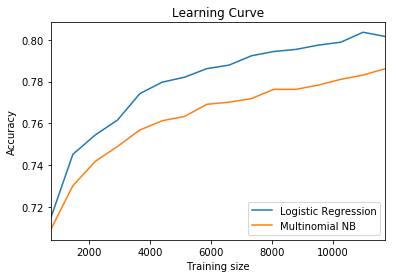

In [40]:
%matplotlib inline

plt.title("Learning Curve")
scores_log = np.array(scores_log)
scores_NB = np.array(scores_NB)
size = np.arange(round(0.05*n),int(0.8*n+1),round(0.05*n))

plt.plot(size, scores_log[:,1], label="Logistic Regression")
plt.plot(size, scores_NB[:,1],label = "Multinomial NB")
plt.xlabel("Training size")
plt.ylabel('Accuracy')
plt.xlim(size.min(),size.max())
plt.legend(loc='lower right')
plt.show()

#### Analysis : -
* With varied range of training data accuracies for **Logistic Regression** ranges from **71% to 80%.**
* Accuracies for **Naive Bayes** range from **70% to 78%.**
* Accuracies for both classifiers are steadily increasing with the addition of more training data.
* A **slight dip in the accuracy** is observed  for Logistic Regression **when training data is increased from 75% to 80%**. Since the difference in accuracy is just 0.2%, it can be attributed to noise in the data set.

### Conclusion: -
* From individual airline analysis, combined airline analysis and from Learning Curve its observed that for this data set **Logistic Regression is having a superior performance when compared to Multinomial Naive Bayes.**
* Both the learners improve their accuracies with the addition of more training data.